<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-06/Info-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


# Download and show data

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


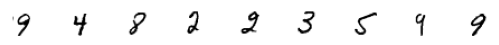

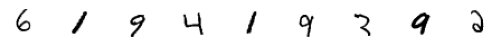

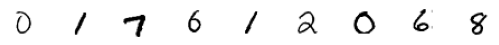

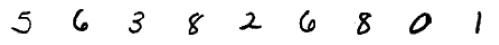

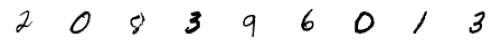

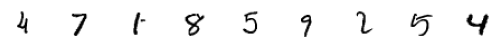

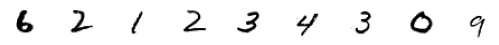

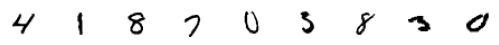

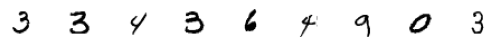

In [4]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

# 10 Classes

In [5]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Data Normalization

In [6]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [8]:
random_input = tensorflow.keras.layers.Input(shape = 50)
control_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(64)(random_input)

#Class Input
x2 = tensorflow.keras.layers.Dense(32)(control_input)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Dense(5*5*64)(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Reshape((5, 5, 64))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, control_input], outputs=generated_image)
generator_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           3264        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           352         input_2[0][0]                    
______________________________________________________________________________________________

# Define Discriminator

In [12]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(4,4))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

features = tensorflow.keras.layers.Flatten()(x)

d_out = tensorflow.keras.layers.Dense(1)(features)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(d_out)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)

info = tensorflow.keras.layers.Dense(10)(features)
info_output = tensorflow.keras.layers.Activation('softmax')(info)

info_network = tensorflow.keras.models.Model(inputs=image_input, outputs=info_output)

print (discriminator_network.summary())
print (info_network.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 128)       1280      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 6, 128)         147584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 6, 6, 128)         512       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)         1475

In [13]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

info_network.compile(loss='categorical_crossentropy', optimizer=adam_optimizer)

# Define combined model: Info-GAN

In [14]:
discriminator_network.trainable=False

g_output = generator_network([random_input, control_input])

d_output = discriminator_network(g_output)
info_output = info_network(g_output)

info_gan_model = tensorflow.keras.models.Model(inputs = [random_input, control_input], outputs=[d_output, info_output])
info_gan_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 28, 28, 1)    531425      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_7 (Functional)            (None, 1)            428929      model[0][0]                

# Compiling InfoGAN

In [18]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
info_gan_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer)

# Define Utility Functions

In [19]:
indices = [i for i in range(0, len(trainX))]

def encode_control_input(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_control_input(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    control_inputs = []
    for i in range(batch_size):
        control_input = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        control_inputs.append(encode_control_input(control_input))
    control_inputs = np.array(control_inputs)
    return random_noise_batches, control_inputs

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches, control_inputs= get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch([random_noise_batches, control_inputs])
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(10):
        random_noise_batches, _ = get_random_noise(10, noise_size) 
        control_inputs = []
        for bs in range(10):
            control_inputs.append(encode_control_input(k))
        control_inputs = np.array(control_inputs)
        fake_samples = generator_network.predict_on_batch([random_noise_batches, control_inputs])
        plt.figure(figsize=(9, 6))
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
            #plt.title(decode_control_input(control_inputs[i]))
            plt.axis('off')
        plt.show()
    return

# Training Info-GAN

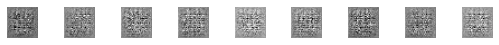

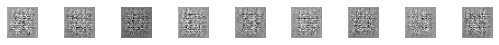

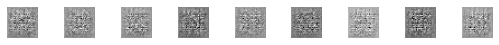

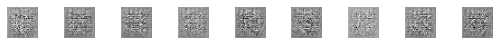

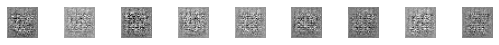

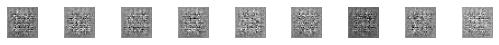

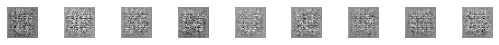

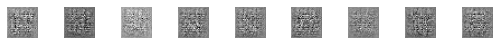

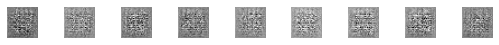

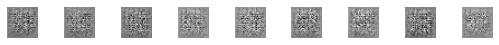

Epoch:0, Step:0, D-Loss:1.389, D-Acc:10.000, G-Loss:2.999, Info-Loss:0.684
Epoch:0, Step:50, D-Loss:0.079, D-Acc:97.000, G-Loss:6.304, Info-Loss:3.760
Epoch:0, Step:100, D-Loss:0.147, D-Acc:93.000, G-Loss:7.117, Info-Loss:4.507
Epoch:0, Step:150, D-Loss:0.052, D-Acc:99.000, G-Loss:7.862, Info-Loss:5.318
Epoch:0, Step:200, D-Loss:0.088, D-Acc:96.000, G-Loss:8.136, Info-Loss:5.443
Epoch:0, Step:250, D-Loss:0.130, D-Acc:94.000, G-Loss:7.268, Info-Loss:4.967
Epoch:0, Step:300, D-Loss:0.095, D-Acc:96.000, G-Loss:8.229, Info-Loss:5.858
Epoch:0, Step:350, D-Loss:0.159, D-Acc:94.000, G-Loss:6.439, Info-Loss:4.223
Epoch:0, Step:400, D-Loss:0.088, D-Acc:97.000, G-Loss:6.769, Info-Loss:4.659
Epoch:0, Step:450, D-Loss:0.117, D-Acc:95.000, G-Loss:6.056, Info-Loss:3.898
Epoch:1, Step:0, D-Loss:0.083, D-Acc:98.000, G-Loss:6.766, Info-Loss:4.861
Epoch:1, Step:50, D-Loss:0.201, D-Acc:89.000, G-Loss:5.915, Info-Loss:3.985
Epoch:1, Step:100, D-Loss:0.184, D-Acc:93.000, G-Loss:5.747, Info-Loss:4.000
Epoch

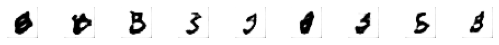

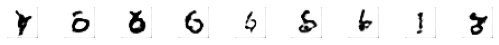

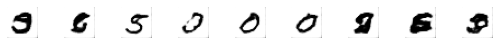

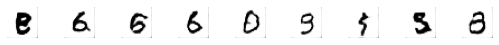

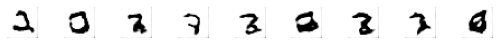

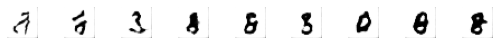

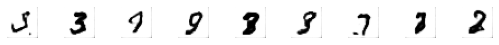

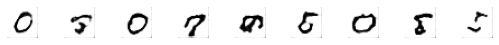

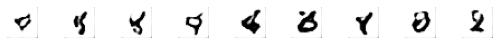

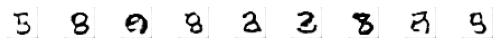

Epoch:5, Step:0, D-Loss:0.203, D-Acc:92.000, G-Loss:2.536, Info-Loss:1.874
Epoch:5, Step:50, D-Loss:0.517, D-Acc:75.000, G-Loss:1.680, Info-Loss:1.063
Epoch:5, Step:100, D-Loss:0.145, D-Acc:97.000, G-Loss:5.535, Info-Loss:5.010
Epoch:5, Step:150, D-Loss:0.164, D-Acc:94.000, G-Loss:2.617, Info-Loss:2.132
Epoch:5, Step:200, D-Loss:0.296, D-Acc:83.000, G-Loss:6.540, Info-Loss:5.968
Epoch:5, Step:250, D-Loss:0.151, D-Acc:95.000, G-Loss:2.792, Info-Loss:2.223
Epoch:5, Step:300, D-Loss:0.218, D-Acc:94.000, G-Loss:3.026, Info-Loss:2.507
Epoch:5, Step:350, D-Loss:0.172, D-Acc:95.000, G-Loss:2.924, Info-Loss:2.447
Epoch:5, Step:400, D-Loss:0.396, D-Acc:82.000, G-Loss:1.424, Info-Loss:0.884
Epoch:5, Step:450, D-Loss:0.258, D-Acc:90.000, G-Loss:5.777, Info-Loss:5.306
Epoch:6, Step:0, D-Loss:0.260, D-Acc:89.000, G-Loss:5.579, Info-Loss:5.130
Epoch:6, Step:50, D-Loss:0.244, D-Acc:89.000, G-Loss:2.882, Info-Loss:2.316
Epoch:6, Step:100, D-Loss:0.214, D-Acc:89.000, G-Loss:1.932, Info-Loss:1.452
Epoch

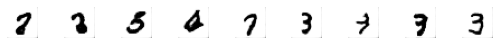

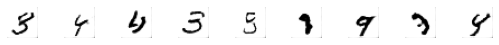

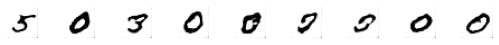

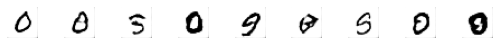

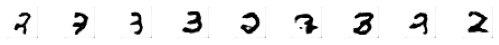

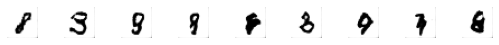

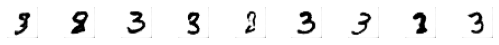

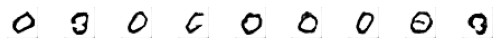

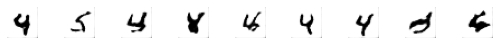

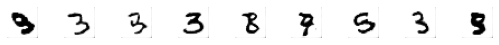

Epoch:10, Step:0, D-Loss:0.241, D-Acc:89.000, G-Loss:2.505, Info-Loss:2.247
Epoch:10, Step:50, D-Loss:0.309, D-Acc:87.000, G-Loss:3.423, Info-Loss:3.198
Epoch:10, Step:100, D-Loss:0.305, D-Acc:88.000, G-Loss:1.322, Info-Loss:1.029
Epoch:10, Step:150, D-Loss:0.157, D-Acc:96.000, G-Loss:1.644, Info-Loss:1.212
Epoch:10, Step:200, D-Loss:0.291, D-Acc:89.000, G-Loss:1.099, Info-Loss:0.815
Epoch:10, Step:250, D-Loss:0.262, D-Acc:90.000, G-Loss:1.950, Info-Loss:1.657
Epoch:10, Step:300, D-Loss:0.263, D-Acc:92.000, G-Loss:0.602, Info-Loss:0.298
Epoch:10, Step:350, D-Loss:0.421, D-Acc:80.000, G-Loss:1.164, Info-Loss:0.954
Epoch:10, Step:400, D-Loss:0.247, D-Acc:92.000, G-Loss:3.631, Info-Loss:3.363
Epoch:10, Step:450, D-Loss:0.358, D-Acc:82.000, G-Loss:5.354, Info-Loss:5.213
Epoch:11, Step:0, D-Loss:0.283, D-Acc:85.000, G-Loss:3.440, Info-Loss:3.270
Epoch:11, Step:50, D-Loss:0.284, D-Acc:89.000, G-Loss:5.933, Info-Loss:5.788
Epoch:11, Step:100, D-Loss:0.433, D-Acc:82.000, G-Loss:2.832, Info-Los

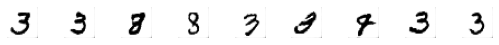

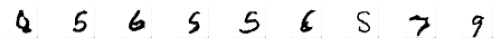

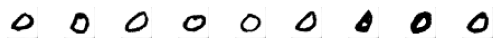

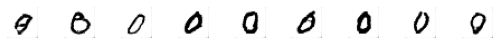

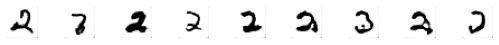

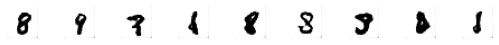

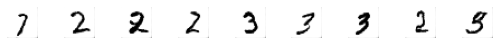

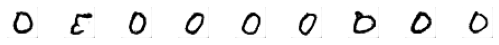

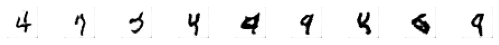

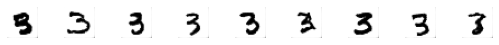

Epoch:15, Step:0, D-Loss:0.372, D-Acc:82.000, G-Loss:3.025, Info-Loss:2.847
Epoch:15, Step:50, D-Loss:0.439, D-Acc:77.000, G-Loss:2.780, Info-Loss:2.649
Epoch:15, Step:100, D-Loss:0.477, D-Acc:79.000, G-Loss:0.868, Info-Loss:0.642
Epoch:15, Step:150, D-Loss:0.342, D-Acc:84.000, G-Loss:2.063, Info-Loss:1.902
Epoch:15, Step:200, D-Loss:0.343, D-Acc:86.000, G-Loss:1.190, Info-Loss:1.013
Epoch:15, Step:250, D-Loss:0.310, D-Acc:90.000, G-Loss:2.575, Info-Loss:2.415
Epoch:15, Step:300, D-Loss:0.277, D-Acc:88.000, G-Loss:2.751, Info-Loss:2.636
Epoch:15, Step:350, D-Loss:0.416, D-Acc:81.000, G-Loss:4.897, Info-Loss:4.783
Epoch:15, Step:400, D-Loss:0.458, D-Acc:76.000, G-Loss:1.708, Info-Loss:1.582
Epoch:15, Step:450, D-Loss:0.456, D-Acc:80.000, G-Loss:3.296, Info-Loss:3.101
Epoch:16, Step:0, D-Loss:0.401, D-Acc:81.000, G-Loss:3.338, Info-Loss:3.201
Epoch:16, Step:50, D-Loss:0.304, D-Acc:88.000, G-Loss:2.434, Info-Loss:2.295
Epoch:16, Step:100, D-Loss:0.403, D-Acc:82.000, G-Loss:1.084, Info-Los

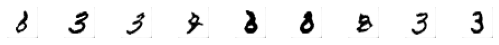

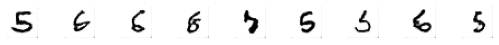

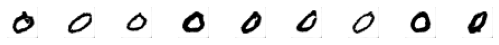

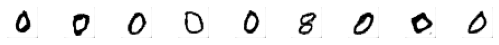

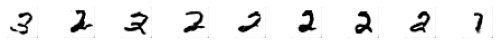

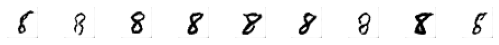

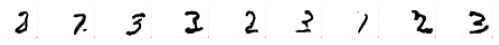

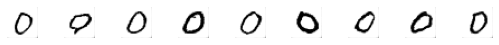

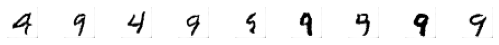

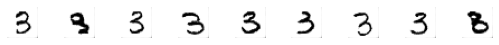

Epoch:20, Step:0, D-Loss:0.388, D-Acc:80.000, G-Loss:0.510, Info-Loss:0.405
Epoch:20, Step:50, D-Loss:0.444, D-Acc:81.000, G-Loss:2.453, Info-Loss:2.363
Epoch:20, Step:100, D-Loss:0.437, D-Acc:84.000, G-Loss:1.475, Info-Loss:1.380
Epoch:20, Step:150, D-Loss:0.436, D-Acc:80.000, G-Loss:2.059, Info-Loss:1.981
Epoch:20, Step:200, D-Loss:0.415, D-Acc:81.000, G-Loss:1.657, Info-Loss:1.578
Epoch:20, Step:250, D-Loss:0.460, D-Acc:78.000, G-Loss:3.690, Info-Loss:3.605
Epoch:20, Step:300, D-Loss:0.461, D-Acc:77.000, G-Loss:1.507, Info-Loss:1.414
Epoch:20, Step:350, D-Loss:0.495, D-Acc:78.000, G-Loss:1.030, Info-Loss:0.924
Epoch:20, Step:400, D-Loss:0.515, D-Acc:75.000, G-Loss:2.770, Info-Loss:2.688
Epoch:20, Step:450, D-Loss:0.487, D-Acc:76.000, G-Loss:2.407, Info-Loss:2.360
Epoch:21, Step:0, D-Loss:0.486, D-Acc:75.000, G-Loss:3.384, Info-Loss:3.278
Epoch:21, Step:50, D-Loss:0.480, D-Acc:77.000, G-Loss:1.680, Info-Loss:1.633
Epoch:21, Step:100, D-Loss:0.401, D-Acc:82.000, G-Loss:2.169, Info-Los

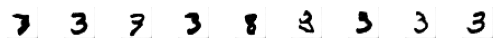

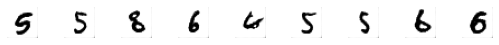

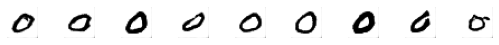

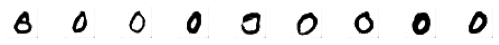

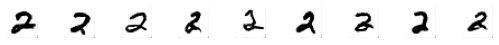

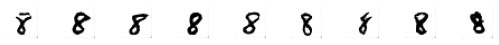

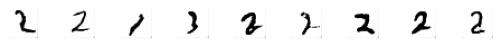

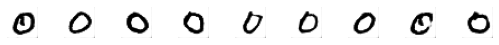

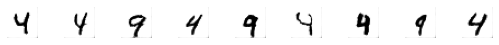

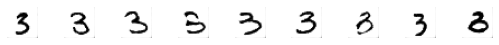

Epoch:25, Step:0, D-Loss:0.368, D-Acc:86.000, G-Loss:2.612, Info-Loss:2.526
Epoch:25, Step:50, D-Loss:0.462, D-Acc:78.000, G-Loss:2.270, Info-Loss:2.235
Epoch:25, Step:100, D-Loss:0.482, D-Acc:72.000, G-Loss:1.908, Info-Loss:1.873
Epoch:25, Step:150, D-Loss:0.400, D-Acc:83.000, G-Loss:1.841, Info-Loss:1.805
Epoch:25, Step:200, D-Loss:0.492, D-Acc:78.000, G-Loss:1.507, Info-Loss:1.426
Epoch:25, Step:250, D-Loss:0.474, D-Acc:80.000, G-Loss:0.966, Info-Loss:0.915
Epoch:25, Step:300, D-Loss:0.529, D-Acc:70.000, G-Loss:0.462, Info-Loss:0.318
Epoch:25, Step:350, D-Loss:0.449, D-Acc:78.000, G-Loss:0.935, Info-Loss:0.878
Epoch:25, Step:400, D-Loss:0.560, D-Acc:67.000, G-Loss:1.866, Info-Loss:1.793
Epoch:25, Step:450, D-Loss:0.576, D-Acc:69.000, G-Loss:0.304, Info-Loss:0.250
Epoch:26, Step:0, D-Loss:0.547, D-Acc:68.000, G-Loss:1.799, Info-Loss:1.769
Epoch:26, Step:50, D-Loss:0.514, D-Acc:74.000, G-Loss:1.520, Info-Loss:1.455
Epoch:26, Step:100, D-Loss:0.477, D-Acc:77.000, G-Loss:1.769, Info-Los

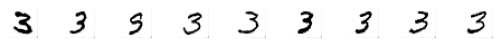

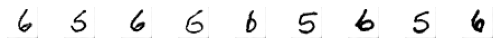

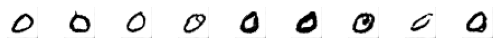

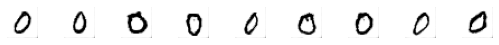

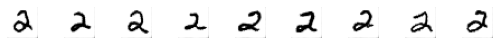

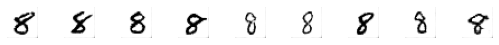

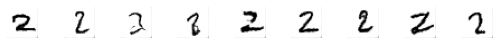

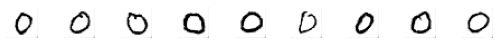

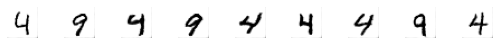

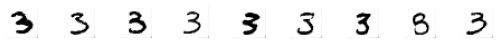

Epoch:30, Step:0, D-Loss:0.421, D-Acc:80.000, G-Loss:0.129, Info-Loss:0.083
Epoch:30, Step:50, D-Loss:0.514, D-Acc:72.000, G-Loss:1.288, Info-Loss:1.252
Epoch:30, Step:100, D-Loss:0.524, D-Acc:70.000, G-Loss:1.124, Info-Loss:1.099
Epoch:30, Step:150, D-Loss:0.534, D-Acc:77.000, G-Loss:1.213, Info-Loss:1.161
Epoch:30, Step:200, D-Loss:0.516, D-Acc:77.000, G-Loss:1.210, Info-Loss:1.187
Epoch:30, Step:250, D-Loss:0.431, D-Acc:83.000, G-Loss:2.467, Info-Loss:2.447
Epoch:30, Step:300, D-Loss:0.558, D-Acc:72.000, G-Loss:1.498, Info-Loss:1.480
Epoch:30, Step:350, D-Loss:0.411, D-Acc:83.000, G-Loss:1.039, Info-Loss:1.011
Epoch:30, Step:400, D-Loss:0.583, D-Acc:66.000, G-Loss:1.028, Info-Loss:0.967
Epoch:30, Step:450, D-Loss:0.429, D-Acc:78.000, G-Loss:1.469, Info-Loss:1.445
Epoch:31, Step:0, D-Loss:0.506, D-Acc:77.000, G-Loss:0.953, Info-Loss:0.910
Epoch:31, Step:50, D-Loss:0.459, D-Acc:80.000, G-Loss:1.729, Info-Loss:1.687
Epoch:31, Step:100, D-Loss:0.513, D-Acc:77.000, G-Loss:1.549, Info-Los

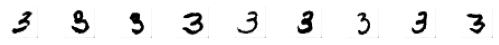

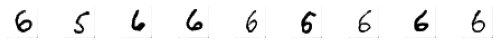

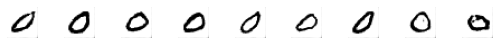

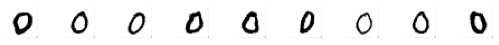

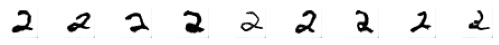

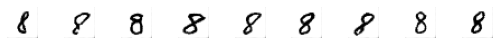

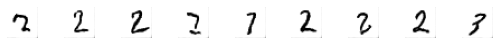

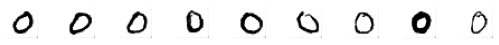

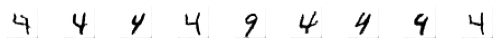

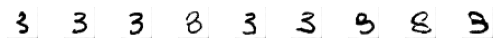

Epoch:35, Step:0, D-Loss:0.500, D-Acc:75.000, G-Loss:2.324, Info-Loss:2.285
Epoch:35, Step:50, D-Loss:0.561, D-Acc:72.000, G-Loss:1.278, Info-Loss:1.248
Epoch:35, Step:100, D-Loss:0.433, D-Acc:82.000, G-Loss:1.045, Info-Loss:1.019
Epoch:35, Step:150, D-Loss:0.547, D-Acc:72.000, G-Loss:2.091, Info-Loss:2.074
Epoch:35, Step:200, D-Loss:0.537, D-Acc:74.000, G-Loss:1.337, Info-Loss:1.314
Epoch:35, Step:250, D-Loss:0.466, D-Acc:75.000, G-Loss:0.620, Info-Loss:0.550
Epoch:35, Step:300, D-Loss:0.450, D-Acc:78.000, G-Loss:0.591, Info-Loss:0.579
Epoch:35, Step:350, D-Loss:0.543, D-Acc:75.000, G-Loss:1.070, Info-Loss:1.057
Epoch:35, Step:400, D-Loss:0.483, D-Acc:80.000, G-Loss:3.240, Info-Loss:3.227
Epoch:35, Step:450, D-Loss:0.521, D-Acc:72.000, G-Loss:1.170, Info-Loss:1.136
Epoch:36, Step:0, D-Loss:0.442, D-Acc:82.000, G-Loss:1.638, Info-Loss:1.602
Epoch:36, Step:50, D-Loss:0.515, D-Acc:70.000, G-Loss:1.145, Info-Loss:1.075
Epoch:36, Step:100, D-Loss:0.564, D-Acc:71.000, G-Loss:1.551, Info-Los

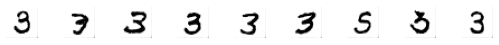

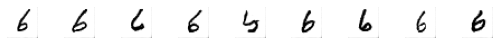

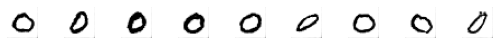

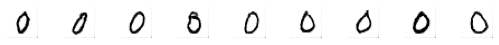

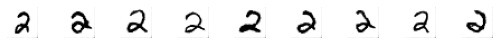

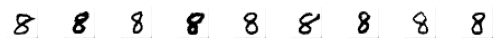

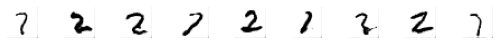

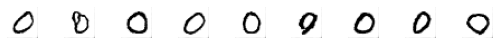

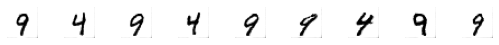

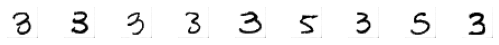

Epoch:40, Step:0, D-Loss:0.493, D-Acc:76.000, G-Loss:0.580, Info-Loss:0.569
Epoch:40, Step:50, D-Loss:0.482, D-Acc:81.000, G-Loss:1.408, Info-Loss:1.392
Epoch:40, Step:100, D-Loss:0.526, D-Acc:69.000, G-Loss:1.366, Info-Loss:1.336
Epoch:40, Step:150, D-Loss:0.486, D-Acc:72.000, G-Loss:1.984, Info-Loss:1.959
Epoch:40, Step:200, D-Loss:0.469, D-Acc:80.000, G-Loss:2.225, Info-Loss:2.216
Epoch:40, Step:250, D-Loss:0.527, D-Acc:75.000, G-Loss:0.548, Info-Loss:0.530
Epoch:40, Step:300, D-Loss:0.596, D-Acc:65.000, G-Loss:1.303, Info-Loss:1.280
Epoch:40, Step:350, D-Loss:0.556, D-Acc:73.000, G-Loss:2.174, Info-Loss:2.134
Epoch:40, Step:400, D-Loss:0.576, D-Acc:70.000, G-Loss:0.488, Info-Loss:0.460
Epoch:40, Step:450, D-Loss:0.546, D-Acc:73.000, G-Loss:1.732, Info-Loss:1.680
Epoch:41, Step:0, D-Loss:0.554, D-Acc:70.000, G-Loss:1.817, Info-Loss:1.808
Epoch:41, Step:50, D-Loss:0.596, D-Acc:66.000, G-Loss:1.422, Info-Loss:1.399
Epoch:41, Step:100, D-Loss:0.529, D-Acc:75.000, G-Loss:1.895, Info-Los

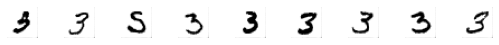

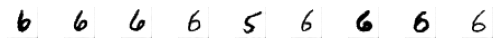

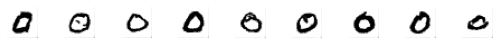

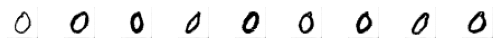

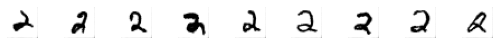

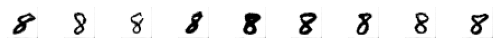

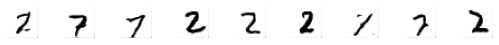

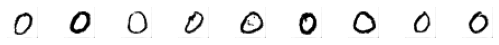

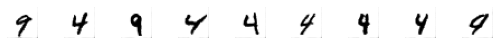

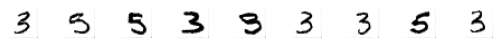

Epoch:45, Step:0, D-Loss:0.525, D-Acc:76.000, G-Loss:3.206, Info-Loss:3.190
Epoch:45, Step:50, D-Loss:0.529, D-Acc:76.000, G-Loss:0.288, Info-Loss:0.277
Epoch:45, Step:100, D-Loss:0.542, D-Acc:71.000, G-Loss:1.515, Info-Loss:1.499
Epoch:45, Step:150, D-Loss:0.388, D-Acc:86.000, G-Loss:3.497, Info-Loss:3.484
Epoch:45, Step:200, D-Loss:0.526, D-Acc:67.000, G-Loss:0.244, Info-Loss:0.231
Epoch:45, Step:250, D-Loss:0.559, D-Acc:68.000, G-Loss:3.260, Info-Loss:3.237
Epoch:45, Step:300, D-Loss:0.530, D-Acc:75.000, G-Loss:1.872, Info-Loss:1.854
Epoch:45, Step:350, D-Loss:0.437, D-Acc:80.000, G-Loss:0.136, Info-Loss:0.106
Epoch:45, Step:400, D-Loss:0.488, D-Acc:78.000, G-Loss:3.734, Info-Loss:3.729
Epoch:45, Step:450, D-Loss:0.515, D-Acc:72.000, G-Loss:1.721, Info-Loss:1.712
Epoch:46, Step:0, D-Loss:0.491, D-Acc:74.000, G-Loss:0.643, Info-Loss:0.628
Epoch:46, Step:50, D-Loss:0.581, D-Acc:65.000, G-Loss:2.614, Info-Loss:2.594
Epoch:46, Step:100, D-Loss:0.499, D-Acc:75.000, G-Loss:0.323, Info-Los

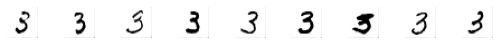

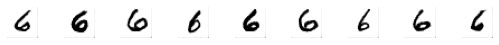

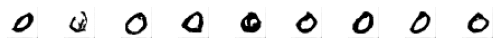

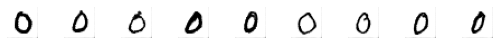

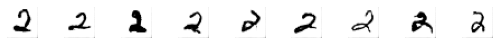

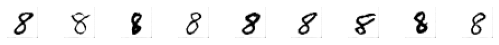

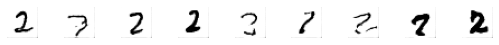

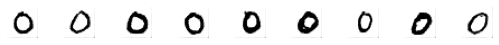

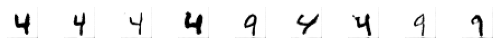

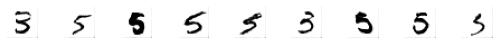

Epoch:50, Step:0, D-Loss:0.502, D-Acc:78.000, G-Loss:1.012, Info-Loss:1.001
Epoch:50, Step:50, D-Loss:0.604, D-Acc:63.000, G-Loss:4.189, Info-Loss:4.171
Epoch:50, Step:100, D-Loss:0.569, D-Acc:71.000, G-Loss:4.055, Info-Loss:4.046
Epoch:50, Step:150, D-Loss:0.563, D-Acc:73.000, G-Loss:1.428, Info-Loss:1.398
Epoch:50, Step:200, D-Loss:0.708, D-Acc:61.000, G-Loss:1.034, Info-Loss:1.020
Epoch:50, Step:250, D-Loss:0.557, D-Acc:72.000, G-Loss:0.042, Info-Loss:0.031
Epoch:50, Step:300, D-Loss:0.393, D-Acc:82.000, G-Loss:0.380, Info-Loss:0.351
Epoch:50, Step:350, D-Loss:0.503, D-Acc:75.000, G-Loss:0.421, Info-Loss:0.414
Epoch:50, Step:400, D-Loss:0.591, D-Acc:69.000, G-Loss:1.994, Info-Loss:1.989
Epoch:50, Step:450, D-Loss:0.436, D-Acc:75.000, G-Loss:3.037, Info-Loss:3.028
Epoch:51, Step:0, D-Loss:0.543, D-Acc:66.000, G-Loss:2.899, Info-Loss:2.889
Epoch:51, Step:50, D-Loss:0.552, D-Acc:75.000, G-Loss:2.426, Info-Loss:2.415
Epoch:51, Step:100, D-Loss:0.441, D-Acc:81.000, G-Loss:4.072, Info-Los

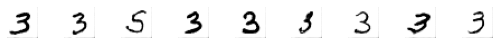

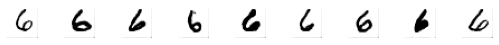

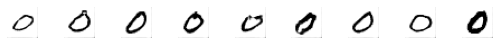

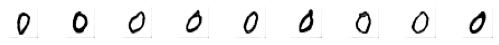

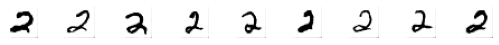

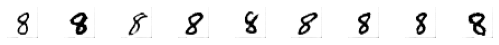

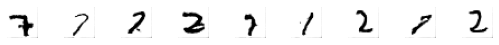

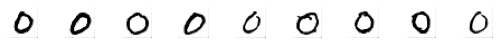

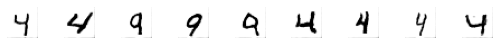

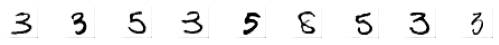

Epoch:55, Step:0, D-Loss:0.525, D-Acc:70.000, G-Loss:0.451, Info-Loss:0.447
Epoch:55, Step:50, D-Loss:0.554, D-Acc:73.000, G-Loss:2.600, Info-Loss:2.581
Epoch:55, Step:100, D-Loss:0.645, D-Acc:61.000, G-Loss:3.637, Info-Loss:3.620
Epoch:55, Step:150, D-Loss:0.496, D-Acc:75.000, G-Loss:3.999, Info-Loss:3.980
Epoch:55, Step:200, D-Loss:0.565, D-Acc:67.000, G-Loss:2.830, Info-Loss:2.813
Epoch:55, Step:250, D-Loss:0.617, D-Acc:68.000, G-Loss:1.153, Info-Loss:1.127
Epoch:55, Step:300, D-Loss:0.501, D-Acc:74.000, G-Loss:0.180, Info-Loss:0.116
Epoch:55, Step:350, D-Loss:0.390, D-Acc:80.000, G-Loss:0.135, Info-Loss:0.129
Epoch:55, Step:400, D-Loss:0.578, D-Acc:65.000, G-Loss:1.456, Info-Loss:1.448
Epoch:55, Step:450, D-Loss:0.464, D-Acc:79.000, G-Loss:3.863, Info-Loss:3.793
Epoch:56, Step:0, D-Loss:0.543, D-Acc:72.000, G-Loss:0.528, Info-Loss:0.513
Epoch:56, Step:50, D-Loss:0.733, D-Acc:59.000, G-Loss:0.507, Info-Loss:0.489
Epoch:56, Step:100, D-Loss:0.431, D-Acc:83.000, G-Loss:0.168, Info-Los

KeyboardInterrupt: ignored

In [20]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 50

for i in range(0, epochs):
    if (i%5 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_samples = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_samples, output_labels)
        
        noise_batches, control_inputs = get_random_noise(batch_size, noise_size)
        info_gan_input = [noise_batches, control_inputs]
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        d_output = np.ones((batch_size))
        info_output = control_inputs
        info_gan_output = [d_output, info_output]
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = info_gan_model.train_on_batch(info_gan_input, info_gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f, Info-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0], loss_g[1]))
            

# Results

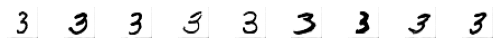

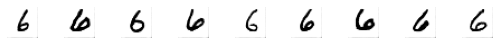

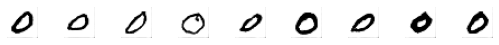

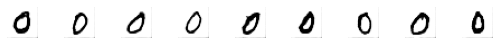

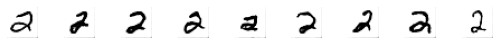

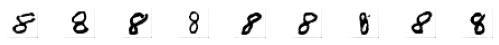

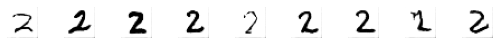

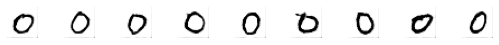

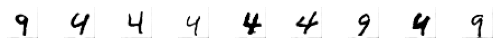

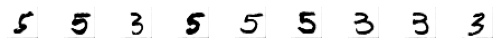

-----------------------------------------------------------------------------


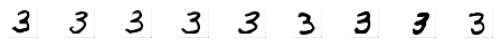

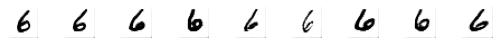

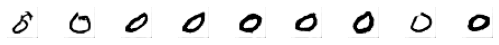

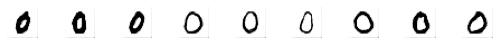

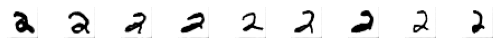

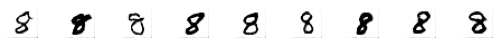

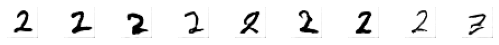

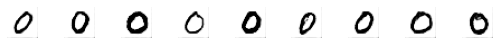

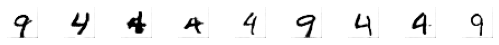

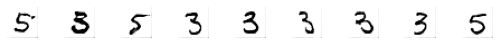

-----------------------------------------------------------------------------


In [21]:
#Generating Unlimited samples
for i in range(2):
    show_generator_results(generator_network)
    print ("-----------------------------------------------------------------------------")